# 2-layer FNN on Cifar

This is MLP (784-X^W-10) on MNIST. SGD algorithm (lr=0.1) with 100 epoches.

 

In [1]:
import os, sys
import numpy as np
from matplotlib.pyplot import *
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import itertools


%matplotlib inline

In [2]:
""" Extract final stats from resman's diary file"""
def extract_num(lines0):

    valid_loss_str     = lines0[-5]
    valid_accuracy_str = lines0[-6]
    train_loss_str     = lines0[-8]
    train_accuracy_str = lines0[-9]
    run_time_str       = lines0[-10]

    valid_loss     = float(valid_loss_str.split( )[-1])
    valid_accuracy = float(valid_accuracy_str.split( )[-1])
    train_loss     = float(train_loss_str.split( )[-1])
    train_accuracy = float(train_accuracy_str.split( )[-1])
    run_time       = float(run_time_str.split( )[-1])
    
    return valid_loss, valid_accuracy, train_loss, train_accuracy, run_time

""" Extract number of total parameters for each net config from resman's diary file"""
def parse_num_params(line0):
    line_str = ''.join(lines0)
    idx = line_str.find("Total params")
    param_str = line_str[idx+14:idx+14+20] # 14 is the length of string "Total params: "
    param_num = param_str.split("\n")[0]
    return int(locale.atof(param_num))

#### Extract results from diary file

    1. Number of params
    2. Loss/Accuarcy for training/testing
    3. Runing time

In [28]:
results_dir = '../results/fnn_cifar_l2_run2'
       
depth = [1,2,3,4,5]
width = [50,100,200,400]
# dim   = [0,600,800,1000,1250,1500]

sr=0.9 # solved ratio

########## 1. filename list of diary ########################
diary_names = []
for subdir, dirs, files in os.walk(results_dir):
    for file in files:
        if file == 'diary':
            fname = os.path.join(subdir, file)
            diary_names.append(fname)

# print diary_names            
dim_ = []            
for f in diary_names: 
    dim_.append( int(f.split('/')[-2].split('_')[-3]  ) )         

dim = list(set(dim)) 
dim = sorted(dim) 
 
print dim
             
             


########## 2. Construct stats (width, depth, dim) ##########
# acc_test_all : Tensor (width, depth, dim)
# num_param_all: Tensor (width, depth)
# acc_solved_all:  Tensor (width, depth)
# dim_solved_all:  Tensor (width, depth)
############################################################
nw, nd, nn= len(width), len(depth), len(dim)

acc_test_all  = np.zeros((len(width), len(depth), len(dim)))
num_param_all = np.zeros((len(width), len(depth)))
acc_solved_all = np.zeros((len(width), len(depth)))
dim_solved_all = np.ones((len(width), len(depth)))*dim[-1]

mode = 1         # {0: test loss, 1: test acc}
error_files = [] #  record the error file

# 2.1 construct acc_test_all and num_param_all
for id_w in range(len(width)):
    w = width[id_w]
    for id_ll in range(len(depth)):
        ll = depth[id_ll]
        for id_d in range(len(dim)):
            d = dim[id_d]
            
            # 2.1.1 Read the results, 
            for f in diary_names:
                if '_'+str(d)+'_'+str(ll)+'_'+str(w)+'/' in f:
                    # print "%d is in" % d + f
                    
                    with open(f,'r') as ff:
                        lines0 = ff.readlines()
                        try:
                            R = extract_num(lines0)
                            R = np.array(R)

                        except ValueError:
                            error_files.append((w,ll,d))
                            R = np.zeros(len(R))
                            print "Error. Can not read config: depth %d, width %d and dim %d." % (ll, w, d) 
                            # break
                            
                            
            # 2.1.2 Assign the results
            r = R[mode]  
            acc_test_all[id_w,id_ll,id_d]=r
            if d==0:
                num_param_all[id_w,id_ll]=parse_num_params(lines0) 
                
# 2.2 construct acc_solved_all and dim_solved_all           
for id_w in range(len(width)):
    w = width[id_w]
    for id_ll in range(len(depth)):
        ll = depth[id_ll]
        for id_d in range(len(dim)):
            d = dim[id_d]
            
            r = acc_test_all[id_w,id_ll,id_d]
            if d==0:
                test_acc_bl = r  # 0.5 #   
                # print "Acc goal is: " + str(test_acc_sl) + " for network with depth " + str(ll) + " width "+ str(w)
            else:
                test_acc = r
                if test_acc>test_acc_bl*sr:
                    acc_solved_all[id_w,id_ll]=test_acc
                    dim_solved_all[id_w,id_ll]=d
                    # print "Intrinsic dim is: " + str(d) + " for network with depth " + str(ll) + " width "+ str(w)
                    # print "\n"
                    break
                    

########## 3. Construct Tensors for Analysis (width, depth, dim) ##########                    
acc_base  = acc_test_all[:,:,0]
acc_solve = acc_base*sr
                                       

[0, 1000, 2000, 3000, 4000, 5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750, 7000, 7250, 7500, 7750, 8000, 8500, 9000, 10000, 12500, 15000]


In [26]:
print "Baseline results"
print acc_test_all.shape

print "# Parmas"
print num_param_all

print "Cross-line results"
print acc_solved_all

print "Cross-line Dim"
print dim_solved_all

print "Dim %d results" % dim[-1]
print acc_test_all[:,:,-1]  

Baseline results
(4, 5, 23)
# Parmas
[[  154160.   156710.   159260.   161810.   164360.]
 [  308310.   318410.   328510.   338610.   348710.]
 [  616610.   656810.   697010.   737210.   777410.]
 [ 1233210.  1393610.  1554010.  1714410.  1874810.]]
Cross-line results
[[ 0.4288  0.417   0.4156  0.4194  0.4357]
 [ 0.4185  0.4248  0.4299  0.4294  0.4258]
 [ 0.4475  0.4421  0.4527  0.4539  0.4504]
 [ 0.4595  0.4587  0.4582  0.4682  0.    ]]
Cross-line Dim
[[  4000.   3000.   3000.   3000.   4000.]
 [  3000.   4000.   4000.   4000.   4000.]
 [  5250.   5000.   6250.   7250.   6500.]
 [  6250.   7500.   9000.  12500.  15000.]]
Dim 15000 results
[[ 0.4797  0.4757  0.4654  0.4669  0.4691]
 [ 0.4815  0.4795  0.4679  0.4613  0.4558]
 [ 0.4865  0.474   0.4636  0.4693  0.4624]
 [ 0.4836  0.468   0.4691  0.4633  0.4566]]


#### List the config of depth and width, which yields errors in training

In [5]:
E_width, E_depth, E_dim = [],[],[]
for item in error_files:
    E_width.append(item[0]) 
    E_depth.append(item[1])
    E_dim.append(item[2])

str_E_width = "".join(str(E_width)).replace(',', '')
str_E_depth = "".join(str(E_depth)).replace(',', '')
str_E_dim   = "".join(str(E_dim)).replace(',', '')

print "Error in the following configs: width, depth and dim"
print str_E_width
print str_E_depth
print str_E_dim

print "Shape of accuracy tensor: " + str(acc_test_all.shape)

Error in the following configs: width, depth and dim
[]
[]
[]
Shape of accuracy tensor: (4, 5, 460)


-------------------------

#### Check the accuracy of specific depth and width, along different dim

In [6]:
def check_cfg_results (depth, width, lines0): 
    for d in dim:
        # 1. read the results
        for f in diary_names:
            if '_'+str(d)+'_'+str(depth)+'_'+str(width)+'/' in f:
                # print "%d is in" % d + f
                diary_names_ordered.append(f)
                with open(f,'r') as ff:
                    lines0 = ff.readlines()
                    try:
                        # print lines0
                        param_num = parse_num_params(lines0)
                        R = extract_num(lines0)
                        print R[1]

                    except ValueError:
                        print "Error: Can not read"
                        break                                               

Reshape the tensor to 1D for plots

In [29]:


fig_width = width*len(depth)
fig_depth = list(itertools.chain.from_iterable(itertools.repeat(x, len(width)) for x in depth))

print fig_width
print fig_depth
print num_param_all
print "Ratio of D: " + str(np.max(num_param_all[:])/(np.min(num_param_all[:])+.0))
print dim_solved_all
print "Ratio of D: " + str(np.max(dim_solved_all[:])/(np.min(dim_solved_all[:])+.0))
fig_params_1d = num_param_all.reshape(len(depth)*len(width),order='F')
dim_solved_all_1d = dim_solved_all.reshape(len(depth)*len(width),order='F')
acc_solved_all_1d = acc_solved_all.reshape(len(depth)*len(width),order='F')
print fig_params_1d
print dim_solved_all_1d



dim3 = np.repeat(dim, 4*5, axis=0).reshape([4, 5, len(dim)],order='F')
acc_test_all_d1 =  acc_test_all[:,:,1:].reshape((len(dim)-1)*4*5)
dim_d1 =  dim3[:,:,1:].reshape((len(dim)-1)*4*5)
subspace =  np.array([ (int(dim_d1[i]), acc_test_all_d1[i]) for i in range(len(dim_d1)) ])


print ','.join(['[%i, %s]' % (subspace[n,0], subspace[n,1]) for n in xrange(len(subspace))])


[50, 100, 200, 400, 50, 100, 200, 400, 50, 100, 200, 400, 50, 100, 200, 400, 50, 100, 200, 400]
[1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5]
[[  154160.   156710.   159260.   161810.   164360.]
 [  308310.   318410.   328510.   338610.   348710.]
 [  616610.   656810.   697010.   737210.   777410.]
 [ 1233210.  1393610.  1554010.  1714410.  1874810.]]
Ratio of D: 12.1614556305
[[  4000.   3000.   3000.   3000.   4000.]
 [  3000.   4000.   4000.   4000.   4000.]
 [  5250.   5000.   6250.   7250.   6500.]
 [  6250.   7500.   9000.  12500.  15000.]]
Ratio of D: 5.0
[  154160.   308310.   616610.  1233210.   156710.   318410.   656810.
  1393610.   159260.   328510.   697010.  1554010.   161810.   338610.
   737210.  1714410.   164360.   348710.   777410.  1874810.]
[  4000.   3000.   5250.   6250.   3000.   4000.   5000.   7500.   3000.
   4000.   6250.   9000.   3000.   4000.   7250.  12500.   4000.   4000.
   6500.  15000.]
[1000, 0.3453],[2000, 0.3857],[3000, 0.4142],[4

### Testing Accuracy wrt. Width, Depth and Dim

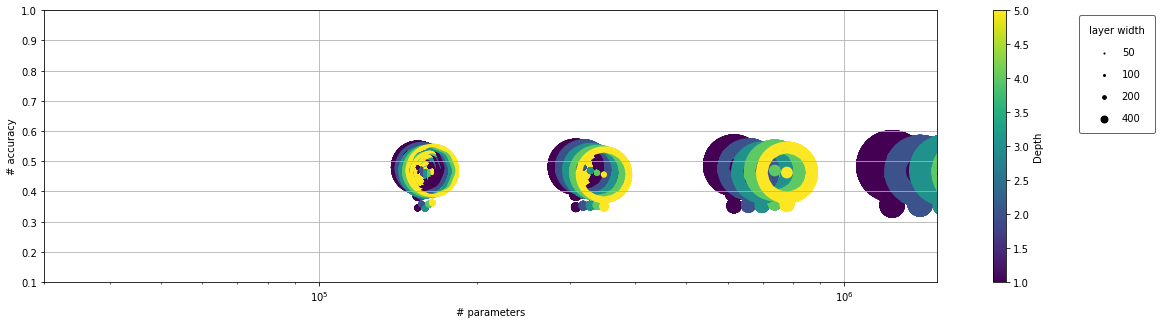

In [8]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns

plt.figure(figsize=(20,5.0))

for i in range(acc_test_all.shape[2]):
    acc = acc_test_all[:,:,i].reshape(len(depth)*len(width),order='F')
    if i==0:
        plt.scatter(fig_params_1d, acc, s=(np.array(fig_width)**1.8)/100, c=fig_depth, edgecolors='k') 
        plt.scatter(fig_params_1d, sr*acc, marker="_", s=300, c='k', edgecolors='r') 
    else:
        plt.scatter(fig_params_1d, acc, s=(np.array(fig_width)**1.8)/100, c=fig_depth, facecolors='None', linewidth=np.array(dim[i])/300.0) 

        
ax = plt.gca()
plt.colorbar(label="Depth")

ax.set_xscale('log')
ax.grid(True)

ax.set_ylim(0.1, 1.0)
ax.set_xlim(0.3E5, 1.5E6)

plt.xlabel('# parameters')
plt.ylabel('# accuracy')

#make a legend:
pws = width
for pw in pws:
    plt.scatter([], [], s=(pw**1.8)/1000, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[0:], l[0:], labelspacing=1.2, title="layer width", borderpad=1, loc='best', bbox_to_anchor=(1.25, 1),
             frameon=True, framealpha=0.6, edgecolor="k", facecolor="w")

 
    

#### Testing Accuracy of Intrinsic dim for #parameters

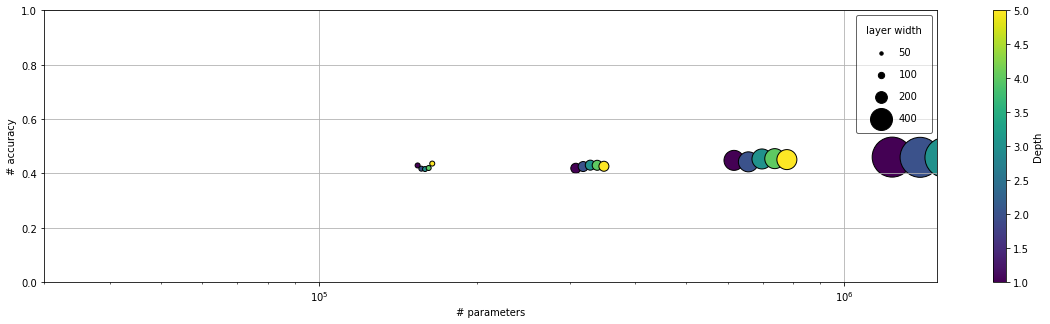

In [9]:
plt.figure(figsize=(20,5))


plt.scatter(fig_params_1d, acc_solved_all_1d, s=(np.array(fig_width)**2.0)/100, c=fig_depth, edgecolors='k') 

ax = plt.gca()
plt.colorbar(label="Depth")

ax.set_xscale('log')
ax.grid(True)

ax.set_ylim(0.0, 1.0)
ax.set_xlim(0.3E5, 1.5E6)


plt.xlabel('# parameters')
plt.ylabel('# accuracy')

#make a legend:
pws = width
for pw in pws:
    plt.scatter([], [], s=(pw**1.8)/100, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[0:], l[0:], labelspacing=1.2, title="layer width", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w")

#### Intrinsic dim for #parameters

/home/users/chunyuan.li/tensorflow/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


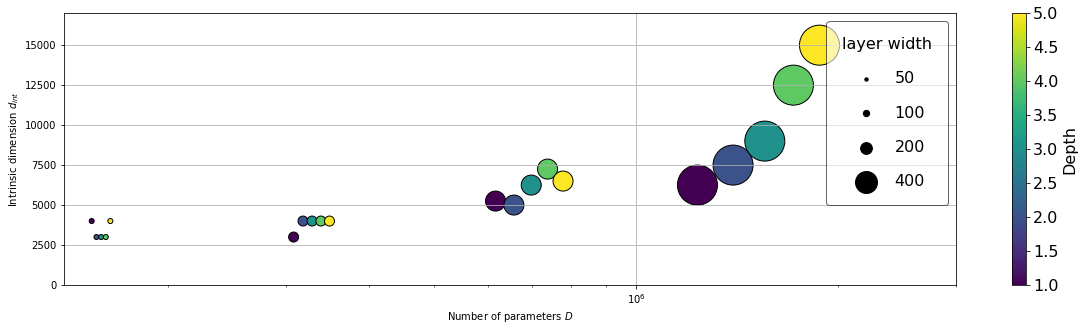

In [10]:
# plt.figure(figsize=(20,5))
fig, ax = subplots(figsize=(20,5) )
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

plt.scatter(fig_params_1d, dim_solved_all_1d, s=(np.array(fig_width)**2.0)/100, c=fig_depth, edgecolors='k') 

ax = plt.gca()
plt.colorbar(label="Depth")

ax.set_xscale('log')

ax.grid(True)
ax.set_ylim(0, 17000)

plt.xlabel('Number of parameters $D$')
plt.ylabel('Intrinsic dimension $d_{int}$')
ax.set_xlim(1.4E5, 3.0E6)

#make a legend:
pws = width
for pw in pws:
    plt.scatter([], [], s=(pw**1.8)/100, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[0:], l[0:], labelspacing=1.2, title="layer width", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w")

fig.savefig("figs/fnn_cifar_dim_global.pdf", bbox_inches='tight')

## Performance comparison with Baseline

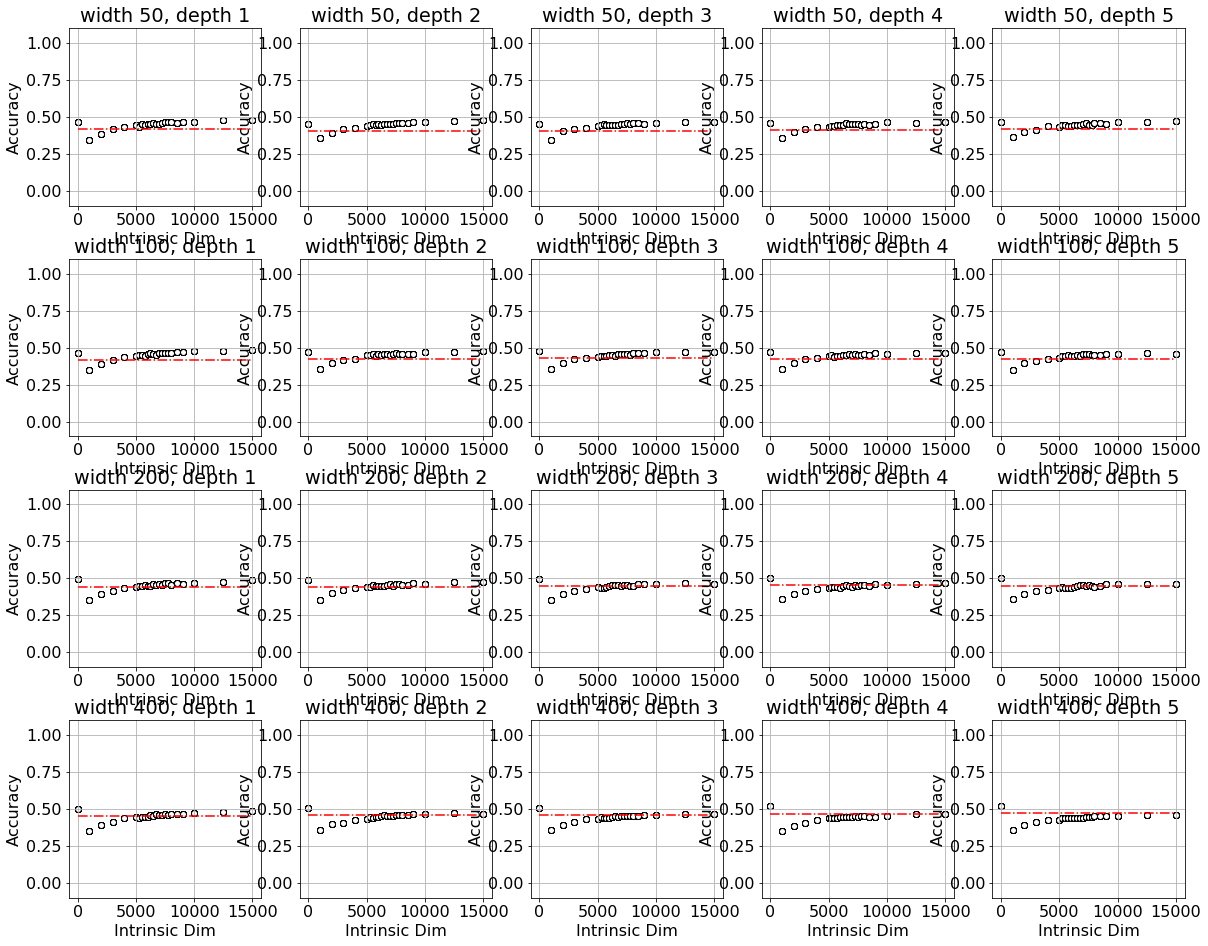

In [12]:
fig = plt.figure(figsize=(20,16))
fig.subplots_adjust(hspace=0.3)


for i in range(nw):
    for j in range(nd):
        id = i*nd+j+1
        ax = plt.subplot(nw, nd, id)

        plt.scatter(dim, acc_test_all[i,j,:], edgecolor="k", facecolor="w" )
        ax.plot(dim, acc_test_all[i,j,0]*np.ones(nn)*sr,'r-.', label="Testing: baseline")
        ax.set_xlabel('Intrinsic Dim')
        ax.set_ylabel('Accuracy')
        ax.set_title('width %d, depth %d' %(width[i], depth[j]))
        plt.grid()
        ax.set_ylim([-0.1,1.1])


In [68]:
""" Extract final stats from resman's diary file"""
def extract_num(lines0, is_reg=False):

    if is_reg:
        valid_loss_str     = lines0[-5]
        valid_accuracy_str = lines0[-6]
        train_loss_str     = lines0[-8]
        train_accuracy_str = lines0[-9]
        average_time_str   = lines0[-10]        
        run_time_str       = lines0[-11]   
        
    else: 
        valid_loss_str     = lines0[-6]
        valid_accuracy_str = lines0[-7]
        train_loss_str     = lines0[-10]
        train_accuracy_str = lines0[-11]
        average_time_str   = lines0[-12]        
        run_time_str       = lines0[-13]

    valid_loss     = float(valid_loss_str.split( )[-1])
    valid_accuracy = float(valid_accuracy_str.split( )[-1])
    train_loss     = float(train_loss_str.split( )[-1])
    train_accuracy = float(train_accuracy_str.split( )[-1])
    run_time       = float(run_time_str.split( )[-1])
    
    return valid_loss, valid_accuracy, train_loss, train_accuracy, run_time

""" Extract number of total parameters for each net config from resman's diary file"""
def parse_num_params(lines0):
    line_str = ''.join(lines0)
    idx = line_str.find("Total params")
    param_str = line_str[idx+14:idx+14+20] # 14 is the length of string "Total params: "
    param_num = param_str.split("\n")[0]
    return int(locale.atof(param_num))

def extract_perf_dim(results_dir):
    # Dim: subspace dim
    # Acc: Accuracy
    
    # filename list of diary
    diary_names = []
    for subdir, dirs, files in os.walk(results_dir):
        for f in files:
            if f == 'diary':
                fname = os.path.join(subdir, f)
                diary_names.append(fname)

    # print diary_names   

    dim = []
    for f in diary_names:
        # print f
        tmp_str = f.split('/')[-2]
        if tmp_str.split('_')[-5]=='MLP':
            d = int(tmp_str.split('_')[-4])
            dim.append(d)

    dim = list(set(dim))
    dim = sorted(dim)  

    print dim

    diary_names_ordered = []
    for d in dim:
        for f in diary_names:
            if '_MLP_'+str(d)+'_' in f and f.split('_')[-5]=='MLP':
                # print "%d is in" % d + f
                diary_names_ordered.append(f)           
    # print diary_names_ordered
    # intrinsic update method
    Dim= []
    Acc = []

    for fname in diary_names_ordered:
        tmp_str = fname.split('/')[-2]
        d = int(tmp_str.split('_')[-4])
        with open(fname,'r') as ff:
            lines0 = ff.readlines()

            try: 
                r = extract_num(lines0,False)[1]
                # print "%d dim:\n"% d + str(r) + "\n"
                Dim.append(d)
                Acc.append(r)

            except ValueError:
                print "%d dim:\n"%d + "Error \n"
                pass

    return Dim, Acc


In [69]:
def plot_perf_dim(Dim, Acc, Cx=None):
    fig, ax = subplots(figsize=(6,5) )

    font = {'size'   : 12}
    matplotlib.rc('font', **font)

    for i in range(len(Dim)):
        if Cx == None:
            if Acc[i]>Acc[0]*0.9 and i>10:
                print "d_{int}="+str(Dim[i]) + ', acc:' + str(Acc[i])
                break
        else: 
            if Acc[i]>Cx and i>10:
                print "d_{int}="+str(Dim[i]) + ', acc:' + str(Acc[i])
                break
                
            
    
    plot(Dim[4:], Acc[4:], 'o', mec='b', mfc=(.8,.8,1), ms=10)
    plot(Dim[i], Acc[i], 'o', mec='b', mfc='b', ms=10)
    axhline(Acc[0], ls='-', color='k',label='baseline')
    axhline(Acc[0] * .9, ls=':', color='k',label='solved')
    plt.legend()
    ax.set_xlabel('Subspace dimension $d$')
    ax.set_ylabel('Validation accuracy')

    # ax.set_title('Cifar: Untied_LeNet' )
    plt.grid()
    ax.set_ylim([0.0,1.01])
    # fig.savefig("figs/fnn_mnistPL_W"+str(width[i])+"_L"+str(depth[j])+".pdf", bbox_inches='tight')


In [70]:
results_root = '/home/users/chunyuan.li/public_results/chun/'


exp_folder = 'results_cifar_MLP'
results_dir = results_root + exp_folder
Dim, Acc= extract_perf_dim(results_dir)

print Dim, Acc
# plot_perf_dim(Dim, Acc, 0.5)

[0, 1000, 2000, 3000, 4000, 5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750, 7000, 7250, 7500, 7750, 8000, 8500, 9000, 10000, 12500, 15000, 20000, 30000, 40000, 50000, 60000, 70000, 79685]
1000 dim:
Error 

1000 dim:
Error 

1000 dim:
Error 

1000 dim:
Error 

1000 dim:
Error 

1000 dim:
Error 

2000 dim:
Error 

2000 dim:
Error 

2000 dim:
Error 

2000 dim:
Error 

2000 dim:
Error 

2000 dim:
Error 

3000 dim:
Error 

3000 dim:
Error 

3000 dim:
Error 

3000 dim:
Error 

3000 dim:
Error 

3000 dim:
Error 

4000 dim:
Error 

4000 dim:
Error 

4000 dim:
Error 

4000 dim:
Error 

4000 dim:
Error 

4000 dim:
Error 

5000 dim:
Error 

5000 dim:
Error 

5000 dim:
Error 

5000 dim:
Error 

5000 dim:
Error 

5000 dim:
Error 

5250 dim:
Error 

5250 dim:
Error 

5250 dim:
Error 

5250 dim:
Error 

5250 dim:
Error 

5250 dim:
Error 

5500 dim:
Error 

5500 dim:
Error 

5500 dim:
Error 

5500 dim:
Error 

5500 dim:
Error 

5500 dim:
Error 

5750 dim:
Error 

5750 dim:
Error 

5750 dim:
Error 

57